In [39]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

#plt.style.use("ggplot")        # if you want a more distinct style
plt.style.use("seaborn-v0_8-pastel")
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]




In [2]:
# Path to your fresh run data
data_dir = Path("/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/")
max_points = 200  # downsampling if necessary
# Load the data
data = np.load(data_dir / "all_backgrounds.npz", allow_pickle=True)
weights_data = np.load(data_dir / "all_weights.npz", allow_pickle=True)
weights = weights_data["weights"]

# Compute alpha (transparency) from weights
w_min, w_max = np.min(weights), np.max(weights)
alphas = 0.1 + 0.9 * (weights - w_min) / (w_max - w_min + 1e-12)

In [3]:
# Prepare arrays for statistics
z_list = []
rho_list = []

for i in range(len(data["z"])):
    z = np.array(data["z"][i], dtype=np.float64)
    rho = np.array(data["rho_tot"][i], dtype=np.float64)

    # Downsample to max_points if necessary
    if len(z) > max_points:
        step = len(z) // max_points
        z = z[::step]
        rho = rho[::step]

    z_list.append(z)
    rho_list.append(rho)

# Stack into 2D arrays: shape = (Nsamples, Npts)
Z = np.stack(z_list)
RHO = np.stack(rho_list)

# Compute statistics
median_rho = np.median(RHO, axis=0)
lower_68 = np.percentile(RHO, 16, axis=0)
upper_68 = np.percentile(RHO, 84, axis=0)
lower_95 = np.percentile(RHO, 2.5, axis=0)
upper_95 = np.percentile(RHO, 97.5, axis=0)

In [65]:
for i in range(Z.shape[0]):
    plt.plot(np.log10(1 + Z[i]), RHO[i], color=colors[2], alpha=alphas[i],linewidth=0.1)

plt.xlabel(r"$\log_{10}(1+z)$", fontsize=14)
plt.ylabel(r"$f_\text{EDE}(z)$", fontsize=14)
#plt.yscale('log')
plt.title("Total EDE Energy Fraction — 500 points", fontsize=16)
plt.xlim(2,5)
#plt.ylim(1e-5,2e5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

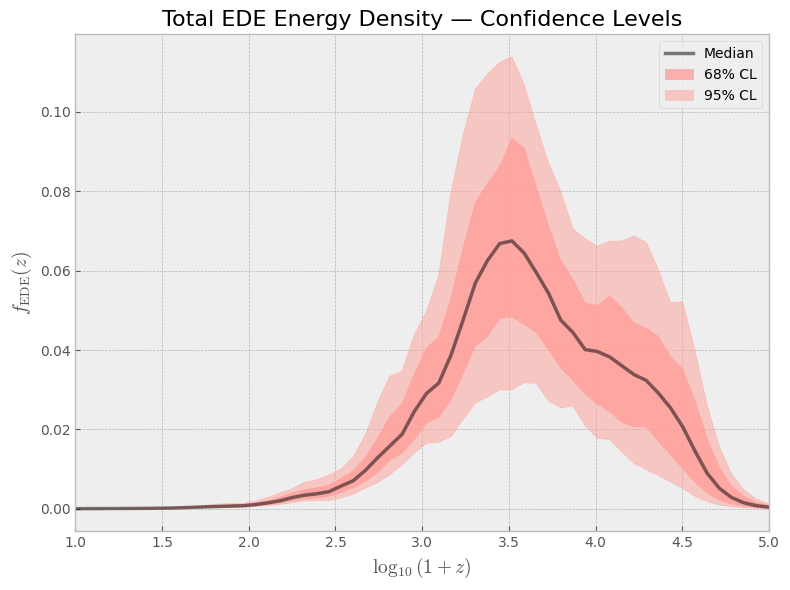

In [64]:
# Plot
plt.figure(figsize=(8,6))
# Median line
plt.plot(np.log10(1 + Z[0]), median_rho,'black',alpha=0.5, lw=2.5, label="Median")
# 68% confidence interval
plt.fill_between(np.log10(1 + Z[0]), lower_68, upper_68, color=colors[2],alpha=0.8, label="68% CL")
# 95% confidence interval
plt.fill_between(np.log10(1 + Z[0]), lower_95, upper_95, color=colors[2],alpha=0.5, label="95% CL")
# Optional: overlay individual weighted samples
#for i in range(Z.shape[0]):
#    plt.plot(np.log10(1 + Z[i]), RHO[i], color='lightblue', alpha=0.01*alphas[i])

plt.xlabel(r"$\log_{10}(1+z)$", fontsize=14)
plt.ylabel(r"$f_\text{EDE}(z)$", fontsize=14)
#plt.yscale('log')
plt.title("EDE Energy Fraction — Confidence Levels", fontsize=16)
plt.xlim(1,5)
#plt.ylim(1e-3,1e5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# H(z) confidence levels

Compare to planck best fit:

  https://arxiv.org/pdf/1807.06209

In [6]:
# Prepare arrays for statistics
z_list = []
H_list = []

for i in range(len(data["z"])):
    z = np.array(data["z"][i], dtype=np.float64)
    H = np.array(data["H"][i], dtype=np.float64)

    # Downsample to max_points if necessary
    if len(z) > max_points:
        step = len(z) // max_points
        z = z[::step]
        H = H[::step]

    z_list.append(z)
    H_list.append(H)

# Stack into 2D arrays: shape = (Nsamples, Npts)
Z = np.stack(z_list)
H = np.stack(H_list)

# Compute statistics
median_H = np.median(H, axis=0)
lower_68_H = np.percentile(H, 16, axis=0)
upper_68_H = np.percentile(H, 84, axis=0)
lower_95_H = np.percentile(H, 2.5, axis=0)
upper_95_H = np.percentile(H, 97.5, axis=0)

/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_20968/1487714146.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


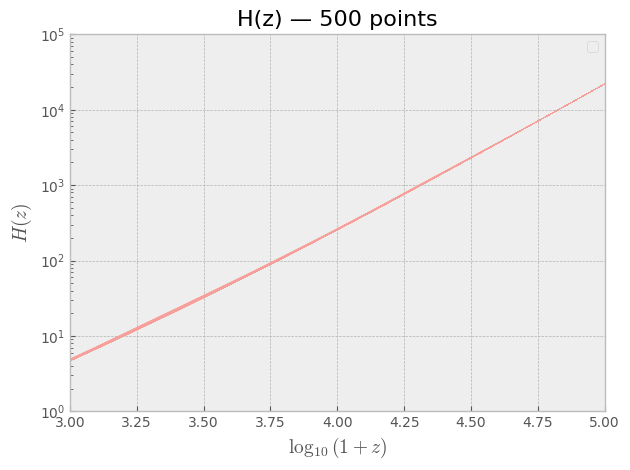

In [58]:
for i in range(Z.shape[0]):
    plt.plot(np.log10(1 + Z[i]), H[i],color=colors[2], alpha=alphas[i],linewidth=0.1)

plt.xlabel(r"$\log_{10}(1+z)$", fontsize=14)
plt.ylabel(r"$H(z)$", fontsize=14)
plt.yscale('log')
plt.title("H(z) — 500 points", fontsize=16)
plt.xlim(3,5)
plt.ylim(1e0,1e5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Compute LCDM

In [8]:
from classy import Class
LambdaCDM = Class()
LambdaCDM.set({'omega_b':0.02237,
               'omega_cdm':0.1200,
               '100theta_s':1.04092,
               'A_s':3.044e-10,
               'n_s':0.9649,
               'tau_reio':0.0544,
               }
               )

#LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})

bg = LambdaCDM.get_background()
z_lcdm = bg['z'] #redshift
H_lcdm = bg['H [1/Mpc]'] #hubble rate

NPTS = 200   # choose 100, 200, 300… depending on how small you want the file

idx = np.round(np.linspace(0, len(z_lcdm) - 1, NPTS)).astype(int)

z_small_lcdm       = z_lcdm[idx]
H_small_lcdm  = H_lcdm[idx]

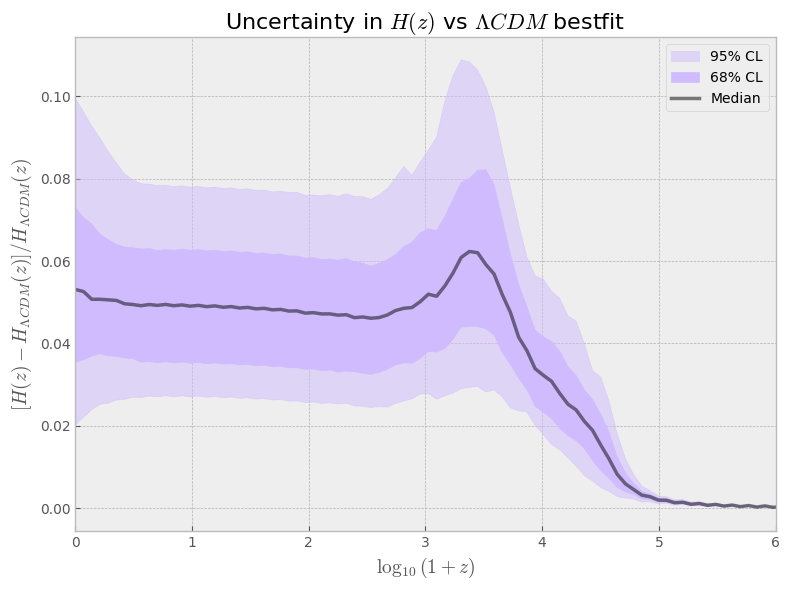

In [61]:
# Plot
plt.figure(figsize=(8,6))
# 95% confidence interval
plt.fill_between(np.log10(1 + Z[0]), (lower_95_H-H_small_lcdm)/H_small_lcdm, (upper_95_H-H_small_lcdm)/H_small_lcdm, color=colors[3],alpha=0.5, label="95% CL")
# 68% confidence interval
plt.fill_between(np.log10(1 + Z[0]), (lower_68_H-H_small_lcdm)/H_small_lcdm, (upper_68_H-H_small_lcdm)/H_small_lcdm, color=colors[3], label="68% CL")
# Median line
plt.plot(np.log10(1 + Z[0]), (median_H-H_small_lcdm)/H_small_lcdm, color='black',alpha=0.5, lw=2.5, label="Median")

plt.xlabel(r"$\log_{10}(1+z)$", fontsize=14)
#plt.yscale('log')
plt.ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$", fontsize=14)
plt.xlim(0,6)
plt.title(r"Uncertainty in $H(z)$ vs $\Lambda CDM$ bestfit", fontsize=16)
#plt.ylim(1e1,1e4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()